# Exploration and Prediction for Structured Data

### Based on Kaggles "Corporación Favorita Grocery Sales Forecasting" Competion

### Using Random Forests and Deep Learning Based on fast.ai Library

The task of exploration and prediction based on structured data is common in industry, but less common in academics. I am particularly interested in this and my goal here is to have a blueprint for that task. I will document a step by step approach to exploration and prediction for a structured data set, and the [Kaggle "Corporación Favorita Grocery Sales Forecasting" competion](https://www.kaggle.com/c/favorita-grocery-sales-forecasting) will be used as the illustrating example throughout.

My starting point is the analyses made in the corresponding [fastai](http://course.fast.ai) [machine learning](http://forums.fast.ai/t/another-treat-early-access-to-intro-to-machine-learning-videos/6826) and [deep learning](http://course.fast.ai/lessons/lesson4.html) lessons. The ML course describes exploration of structured data (especially the [Kaggle Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers)) with random forests (starting with this [notebook](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson1-rf.ipynb)), and the DL course describes prediction using deep learning for the [Kaggle Rossmann competition](https://www.kaggle.com/c/rossmann-store-sales) in this [notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb). The "Grocery" competion should be similar enough to Rossmann, so I want to try and replicate what I learned on that example.

If I understood [Jeremy](http://www.fast.ai/about/#jeremy) correctly, it is quite sufficient today to use [Random Forest](https://en.wikipedia.org/wiki/Random_forest) for exploration and [Deep Learning](https://en.wikipedia.org/wiki/Deep_learning) for prediction, because the two cover a large portion of what you will ever need in machine learning. That is why I focus only on those two technologies and I think they should be helpful as a starting point for most situations.

I have tried to use some of the ideas from [Data Science Primer](https://elitedatascience.com/primer) for structuring this analysis. There is this picture here telling us something about the tasks ahead. In retrospect I would give "data cleaning", or call it "data wrangling", a larger percentage, at least for this data set.

<img src="https://elitedatascience.com/wp-content/uploads/2018/05/What-Goes-Into-a-Successful-Model.jpg" height="80%" width="80%"/>

## 1. Preparation

### 1.1 Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

### 1.2 Data

Data was downloaded from the [Kaggle data page](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data)

In [4]:
PATH = "data/grocery/"

In [5]:
[x for x in Path(PATH).iterdir() if x.is_file()]

[PosixPath('data/grocery/train.csv'),
 PosixPath('data/grocery/items.csv'),
 PosixPath('data/grocery/transactions.csv'),
 PosixPath('data/grocery/submission.csv'),
 PosixPath('data/grocery/holidays_events.csv'),
 PosixPath('data/grocery/test.csv'),
 PosixPath('data/grocery/oil.csv'),
 PosixPath('data/grocery/sample_submission.csv'),
 PosixPath('data/grocery/stores.csv')]

### 1.3 Import Data

In [5]:
dtypes = {'id': np.uint32,
          'store_nbr': np.uint8, 
          'item_nbr': np.uint32, 
          'unit_sales': np.float32,
          'class': np.uint16,
          'perishable': np.bool,
          'dcoilwtico':np.float16,
          'onpromotion': np.bool,
          'transactions':np.uint16,
          'cluster': np.uint32}

In [6]:
%time train = pd.read_csv(f'{PATH}train.csv', low_memory=False, parse_dates=['date'], infer_datetime_format=True, dtype=dtypes)

Wall time: 2min 19s


In [8]:
stores = pd.read_csv(f'{PATH}stores.csv', dtype=dtypes)

In [9]:
holidays_events = pd.read_csv(f'{PATH}holidays_events.csv', low_memory=False, parse_dates=['date'], infer_datetime_format=True, 
                             dtype=dtypes)

In [10]:
test = pd.read_csv(f'{PATH}test.csv', low_memory=False, parse_dates=['date'], infer_datetime_format=True, dtype=dtypes)

In [11]:
items = pd.read_csv(f'{PATH}items.csv', dtype=dtypes)

In [12]:
transactions, oil = [pd.read_csv(f'{PATH}{fname}.csv', parse_dates=['date'], infer_datetime_format=True, dtype=dtypes)
               for fname in ['transactions', 'oil']]

In [13]:
train.to_feather(f'{PATH}data/train_raw')

In [14]:
train = pd.read_feather(f'{PATH}data/train_raw')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


## 2. Exploratory Analysis

Here some wise words from [Data Science Primer](https://elitedatascience.com/primer):

>There’s a big challenge in data science called “Tactical Hell.” You have too many tactics to choose from:  
_Should you clean your data more? Engineer features? Test new algorithms? Etc._  
There’s a lot of trial and error, so how do you avoid chasing dead ends?  
The answer is **Exploratory Analysis**, which means “getting to know” your data.  
Doing this upfront helps you save time and avoid wild goose chases…

### 2.1 Some Basics

#### Number of Observations:

In [15]:
n = len(train); n

125497040

In [16]:
len(test)

3370464

#### Features

In [17]:
tables = train, stores, items, transactions, oil, holidays_events, test

In [18]:
table_names = ['train', 'stores', 'items', 'transactions', 'oil', 'holidays_events', 'test']

In [19]:
for i in range(len(tables)):
    print(table_names[i])
    display(tables[i].head())

train


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,None
1,1,2013-01-01,25,105574,1.0,None
2,2,2013-01-01,25,105575,2.0,None
3,3,2013-01-01,25,108079,1.0,None
4,4,2013-01-01,25,108701,1.0,None


stores


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


items


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,False
1,99197,GROCERY I,1067,False
2,103501,CLEANING,3008,False
3,103520,GROCERY I,1028,False
4,103665,BREAD/BAKERY,2712,True


transactions


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


oil


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.1250
2,2013-01-03,93.0000
3,2013-01-04,93.1250
4,2013-01-07,93.1875


holidays_events


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


test


,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


Data fields are described here: https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data

```unit_sales``` is the target and can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).

Some notes from the Kaggle data page:
* The training data does not include rows for items that had zero ```unit_sales``` for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date.
* The test data has a small number of items that are not contained in the training data. Part of the exercise will be to predict a new item sales based on similar products.
* __transactions.csv__ contains the count of sales transactions for each date, store_nbr combination. It is only included for the training data timeframe.
* __oil.csv__ contains the daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake

### 2.2 Graphical Insights

There follows some graphical insights inspired by this [Kaggle kernel](https://www.kaggle.com/headsortails/shopping-for-insights-favorita-eda)

We will use only a sample of elements to make rendering of visualizations faster. I am then using the ```plt.FuncFormatter``` to set the tick labels of the plot according to the original training set.

In [7]:
train_samp = train[::100]
len(train_samp)

1254971

### 2.3 Unit Sales

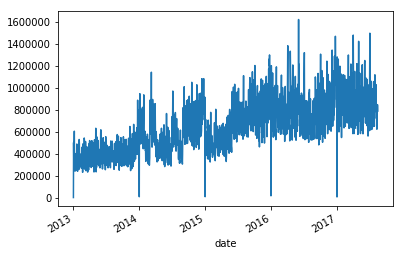

In [8]:
fig = train_samp.groupby('date').sum().unit_sales.plot()
fig.yaxis.set_major_formatter(plt.FuncFormatter(lambda value, tick_number: int(100*value)))

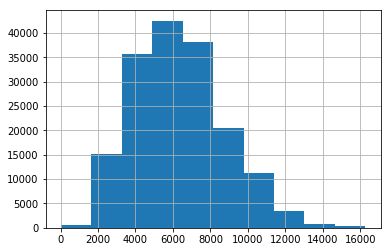

In [9]:
fig = train_samp[['date', 'unit_sales']].groupby('date').sum().unit_sales.hist()
fig.yaxis.set_major_formatter(plt.FuncFormatter(lambda value, tick_number: int(100*value)))

There are a few returns with negative ```unit_sales``` numbers

In [23]:
len(train.unit_sales[train.unit_sales < 0])

7795

In [24]:
int(sum(train.unit_sales[train.unit_sales < 0]))

-143580

### 2.4 Median Number of Transactions Over All Stores

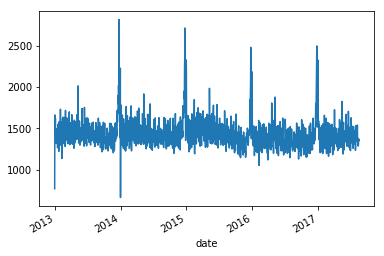

In [25]:
transactions.groupby('date').median().transactions.plot()

There is a strong spike before Christmas with a corresponding drop during the following holidays

### 2.5 Oil Price

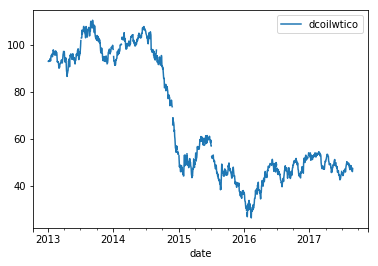

In [26]:
oil.set_index('date').plot()

There is a strong long-term change in oil price with a drop in the second half of 2014. 

## 3. Data Cleaning and Merging

In [28]:
train = pd.read_feather(f'{PATH}data/train_raw')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [29]:
n = len(train); n

125497040

In [30]:
display_all(train.tail().T)

,125497035,125497036,125497037,125497038,125497039
id,125497035,125497036,125497037,125497038,125497039
date,2017-08-15 00:00:00,2017-08-15 00:00:00,2017-08-15 00:00:00,2017-08-15 00:00:00,2017-08-15 00:00:00
store_nbr,54,54,54,54,54
item_nbr,2089339,2106464,2110456,2113914,2116416
unit_sales,4,1,192,198,2
onpromotion,False,True,False,True,False


In [31]:
# skip 2016 data
train = train.loc[train.date>=pd.datetime(2017,1,1)]

In [32]:
n = len(train); n

23808261

### 3.1 Training Data Enhancements

There is an important remark from Jeremy in the forum relating to the issue that the training data does not include rows for items that had zero unit_sales for a store/date combination. **Jeremy**: "Note that the zero sales rows have been removed from the training set - you need to put them back to have any chance of a good model. Most of the kaggle kernels show how."  
(http://forums.fast.ai/t/corporacion-favorita-grocery-sales-forecasting/8359/9)

Jeremy refers to the fact, that most combinations of items + stores do not appear in the training set. But they do appear in the test set, which is somewhat illogical, because how are you supposed to predict something you have never seen?

https://www.kaggle.com/shixw125/1st-place-lgb-model-public-0-506-private-0-511

In [33]:
u_stores = train.store_nbr.unique()
u_items = train.item_nbr.unique()
u_dates = train.date.unique()

In [34]:
train.set_index(["store_nbr", "item_nbr", "date"], inplace=True)

In [35]:
%time train=train.reindex(pd.MultiIndex.from_product((u_stores, u_items, u_dates), names = ['store_nbr', 'item_nbr', 'date', ])).reset_index()

CPU times: user 6min 5s, sys: 11.6 s, total: 6min 17s
Wall time: 6min 16s


In [36]:
n = len(train); n

49252644

In [37]:
train.unit_sales.fillna(0, inplace=True)
train.onpromotion.fillna(False, inplace=True)

In [38]:
display_all(train.tail().T)

,49252639,49252640,49252641,49252642,49252643
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0,0,0,0,0
onpromotion,False,False,False,False,False


**TODO**: Everyone is combining test and train to do the training, so maybe do the same:

https://www.kaggle.com/shixw125/1st-place-lgb-model-public-0-506-private-0-511

In [39]:
print('train')
train.head()

train


,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,25,99197,2017-01-01,101688779.0,1.0,False
1,25,99197,2017-01-02,NaN,0.0,False
2,25,99197,2017-01-03,101853597.0,2.0,False
3,25,99197,2017-01-04,101962201.0,4.0,False
4,25,99197,2017-01-05,102067019.0,2.0,False


In [40]:
train.to_feather(f'{PATH}data/grocery_train')

In [41]:
train = pd.read_feather(f'{PATH}data/grocery_train')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [42]:
pd.options.display.float_format = '{:,.2f}'.format

In [43]:
train.describe(include='all')

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
count,"49,252,644.00","49,252,644.00",49252644,"23,808,261.00","49,252,644.00",49252644
unique,nan,nan,227,nan,nan,2
top,nan,nan,2017-01-11 00:00:00,nan,nan,False
freq,nan,nan,216972,nan,nan,46502995
first,nan,nan,2017-01-01 00:00:00,nan,nan,NaN
last,nan,nan,2017-08-15 00:00:00,nan,nan,NaN
mean,27.50,"1,238,099.69",NaN,"113,592,909.00",3.94,NaN
std,15.59,"582,663.07",NaN,"6,872,853.09",17.22,NaN
min,1.00,"96,995.00",NaN,"101,688,779.00","-10,002.00",NaN
25%,14.00,"809,183.00",NaN,"107,640,844.00",0.00,NaN


In [44]:
test.onpromotion.fillna(False, inplace=True)

In [45]:
test.describe(include='all')

,id,date,store_nbr,item_nbr,onpromotion
count,"3,370,464.00",3370464,"3,370,464.00","3,370,464.00",3370464
unique,nan,16,nan,nan,2
top,nan,2017-08-27 00:00:00,nan,nan,False
freq,nan,210654,nan,nan,3171867
first,nan,2017-08-16 00:00:00,nan,nan,NaN
last,nan,2017-08-31 00:00:00,nan,nan,NaN
mean,"127,182,271.50",NaN,27.50,"1,244,798.25",NaN
std,"972,969.29",NaN,15.59,"589,836.22",NaN
min,"125,497,040.00",NaN,1.00,"96,995.00",NaN
25%,"126,339,655.75",NaN,14.00,"805,321.00",NaN


In [46]:
len(test)

3370464

### 3.2 Merge Holidays

Citation from the 1st place winner of the Kaggle competition:  
"useless features: holidays [and] other keys such as: cluster x item, store x family..."

I still have them in for now

In [47]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [48]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [49]:
holidays_events.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'], dtype=object)

In [50]:
%time train = join_df(train, holidays_events, 'date')

CPU times: user 7.59 s, sys: 2.9 s, total: 10.5 s
Wall time: 10.5 s


In [51]:
train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,type,locale,locale_name,description,transferred
0,25,99197,2017-01-01,"101,688,779.00",1.00,False,Holiday,National,Ecuador,Primer dia del ano,True
1,25,99197,2017-01-02,nan,0.00,False,Transfer,National,Ecuador,Traslado Primer dia del ano,False
2,25,99197,2017-01-03,"101,853,597.00",2.00,False,NaN,NaN,NaN,NaN,NaN
3,25,99197,2017-01-04,"101,962,201.00",4.00,False,NaN,NaN,NaN,NaN,NaN
4,25,99197,2017-01-05,"102,067,019.00",2.00,False,NaN,NaN,NaN,NaN,NaN


In [52]:
%time test = join_df(test, holidays_events, 'date')

CPU times: user 384 ms, sys: 44 ms, total: 428 ms
Wall time: 428 ms


In [53]:
train.type.fillna('Work Day', inplace=True)

In [54]:
train.type.unique()

array(['Holiday', 'Transfer', 'Work Day', 'Additional', 'Event'], dtype=object)

In [55]:
test.type.fillna('Work Day', inplace=True)

In [56]:
train.to_feather(f'{PATH}data/grocery_train')
test.to_feather(f'{PATH}data/grocery_test')

In [57]:
train = pd.read_feather(f'{PATH}data/grocery_train')
test = pd.read_feather(f'{PATH}data/grocery_test')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


### 3.3 Merge Stores

In [58]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [59]:
%time train = join_df(train, stores, 'store_nbr')

CPU times: user 8.68 s, sys: 2.78 s, total: 11.5 s
Wall time: 11.5 s


In [60]:
column_name_mapping={'type': 'holiday_type',
                      'locale': 'holiday_locale',
                      'locale_name': 'holiday_locale_name',
                      'description': 'holiday_description',
                      'transferred': 'holiday_transferred',
                      'type_y': 'store_type'}

In [61]:
train.rename(columns=column_name_mapping, inplace=True)

In [62]:
display_all(train.tail().T)

,50120527,50120528,50120529,50120530,50120531
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0.00,0.00,0.00,0.00,0.00
onpromotion,False,False,False,False,False
holiday_type,Transfer,Work Day,Work Day,Work Day,Holiday
holiday_locale,National,None,None,None,Local
holiday_locale_name,Ecuador,None,None,None,Riobamba
holiday_description,Traslado Primer Grito de Independencia,None,None,None,Fundacion de Riobamba


In [63]:
test = join_df(test, stores, 'store_nbr')

In [64]:
test.rename(columns=column_name_mapping, inplace=True)

In [65]:
display_all(test.tail().T)

,3370459,3370460,3370461,3370462,3370463
id,128867499,128867500,128867501,128867502,128867503
date,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00
store_nbr,54,54,54,54,54
item_nbr,2132163,2132318,2132945,2132957,2134244
onpromotion,False,False,False,False,False
holiday_type,Work Day,Work Day,Work Day,Work Day,Work Day
holiday_locale,None,None,None,None,None
holiday_locale_name,None,None,None,None,None
holiday_description,None,None,None,None,None
holiday_transferred,None,None,None,None,None


In [66]:
%%time
train.to_feather(f'{PATH}data/grocery_train')
test.to_feather(f'{PATH}data/grocery_test')

CPU times: user 15.2 s, sys: 5.28 s, total: 20.5 s
Wall time: 54.2 s


In [67]:
train = pd.read_feather(f'{PATH}data/grocery_train')
test = pd.read_feather(f'{PATH}data/grocery_test')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


### 3.4 Merge Items

In [68]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,False
1,99197,GROCERY I,1067,False
2,103501,CLEANING,3008,False
3,103520,GROCERY I,1028,False
4,103665,BREAD/BAKERY,2712,True


In [69]:
%time train = join_df(train, items, 'item_nbr')

CPU times: user 11.2 s, sys: 3.4 s, total: 14.6 s
Wall time: 14.6 s


In [70]:
%time test = join_df(test, items, "item_nbr")

CPU times: user 988 ms, sys: 136 ms, total: 1.12 s
Wall time: 1.12 s


In [71]:
len(train[train.family.isnull()]),len(test[test.family.isnull()])

(0, 0)

In [72]:
display_all(train.tail().T)

,50120527,50120528,50120529,50120530,50120531
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0.00,0.00,0.00,0.00,0.00
onpromotion,False,False,False,False,False
holiday_type,Transfer,Work Day,Work Day,Work Day,Holiday
holiday_locale,National,None,None,None,Local
holiday_locale_name,Ecuador,None,None,None,Riobamba
holiday_description,Traslado Primer Grito de Independencia,None,None,None,Fundacion de Riobamba


In [73]:
display_all(test.tail().T)

,3370459,3370460,3370461,3370462,3370463
id,128867499,128867500,128867501,128867502,128867503
date,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00
store_nbr,54,54,54,54,54
item_nbr,2132163,2132318,2132945,2132957,2134244
onpromotion,False,False,False,False,False
holiday_type,Work Day,Work Day,Work Day,Work Day,Work Day
holiday_locale,None,None,None,None,None
holiday_locale_name,None,None,None,None,None
holiday_description,None,None,None,None,None
holiday_transferred,None,None,None,None,None


### 3.5 Merge Oil

In [74]:
oil.head()

,date,dcoilwtico
0,2013-01-01,nan
1,2013-01-02,93.12
2,2013-01-03,93.00
3,2013-01-04,93.12
4,2013-01-07,93.19


In [75]:
%time train = join_df(train, oil, 'date')

CPU times: user 23.6 s, sys: 4.73 s, total: 28.4 s
Wall time: 28.3 s


In [76]:
display_all(train.tail().T)

,50120527,50120528,50120529,50120530,50120531
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0.00,0.00,0.00,0.00,0.00
onpromotion,False,False,False,False,False
holiday_type,Transfer,Work Day,Work Day,Work Day,Holiday
holiday_locale,National,None,None,None,Local
holiday_locale_name,Ecuador,None,None,None,Riobamba
holiday_description,Traslado Primer Grito de Independencia,None,None,None,Fundacion de Riobamba


In [77]:
len(train[train.dcoilwtico.isnull()])

16489872

Try to fill NAs in some sensible way (could be improved)

In [78]:
train.dcoilwtico = train.groupby(['store_nbr', 'item_nbr'])['dcoilwtico'].transform(lambda group: group.interpolate(limit_direction = 'both'))

In [79]:
len(train[train.dcoilwtico.isnull()])

0

In [80]:
train['dcoilwtico']=train['dcoilwtico'].astype(np.int8)

In [81]:
%time test = join_df(test, oil, 'date')

CPU times: user 1.55 s, sys: 196 ms, total: 1.74 s
Wall time: 1.74 s


In [82]:
len(test[test.dcoilwtico.isnull()])

842616

In [83]:
test.dcoilwtico = test.groupby(['store_nbr', 'item_nbr'])['dcoilwtico'].transform(lambda group: group.interpolate(limit_direction = 'both'))

In [84]:
test['dcoilwtico']=test['dcoilwtico'].astype(np.int8)

In [85]:
len(test[test.dcoilwtico.isnull()])

0

In [86]:
%%time
train.to_feather(f'{PATH}data/grocery_train')
test.to_feather(f'{PATH}data/grocery_test')

CPU times: user 17.6 s, sys: 6.58 s, total: 24.2 s
Wall time: 1min 3s


In [87]:
%%time
train = pd.read_feather(f'{PATH}data/grocery_train')
test = pd.read_feather(f'{PATH}data/grocery_test')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 18.7 s, sys: 7.8 s, total: 26.5 s
Wall time: 26.5 s


### 3.6 Evaluation Function

https://www.kaggle.com/c/favorita-grocery-sales-forecasting#evaluation

Submissions are evaluated on the Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE), calculated as follows:

$$NWRMSLE = \sqrt{ \frac{\sum_{i=1}^n w_i \left( \ln(\hat{y}_i + 1) - \ln(y_i +1)  \right)^2  }{\sum_{i=1}^n w_i}}$$

where for row i, $\hat{y}_i$ is the predicted ```unit_sales``` of an item and $y_i$ is the actual ```unit_sales```; ```n``` is the total number of rows in the test set.

The weights, $w_i$, can be found in the ```items.csv``` file. Perishable items are given a weight of 1.25 where all other items are given a weight of 1.00.

In [88]:
train.unit_sales[:5]

0   1.00
1   0.00
2   2.00
3   4.00
4   2.00
Name: unit_sales, dtype: float32

In [89]:
# Log-transform
# Negative values of unit_sales represent returns of that particular item
# for the prediction, a return means the same as zero_sales - so convert to 0   
train.unit_sales = np.log1p(np.clip(train.unit_sales, 0, None))

In [90]:
train.unit_sales[:5]

0   0.69
1   0.00
2   1.10
3   1.61
4   1.10
Name: unit_sales, dtype: float32

Consider following from LeeKate (https://www.kaggle.com/deeplake/favorita-grocery-data-analysis-model-test)  
test.csv has only values for the period 2017.08.16 ~ 2017.08.20 
hence pick only August data from train.csv, to improve prediction when concerning the seasoning impact etc.

In [ ]:
# train = input['train'][(input['train']['date'].dt.month == 8) & (input['train']['date'].dt.day > 15)]

In [91]:
display_all(train.tail().T)

,50120527,50120528,50120529,50120530,50120531
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0.00,0.00,0.00,0.00,0.00
onpromotion,False,False,False,False,False
holiday_type,Transfer,Work Day,Work Day,Work Day,Holiday
holiday_locale,National,None,None,None,Local
holiday_locale_name,Ecuador,None,None,None,Riobamba
holiday_description,Traslado Primer Grito de Independencia,None,None,None,Fundacion de Riobamba


In [92]:
%%time
train.to_feather(f'{PATH}data/grocery_train')
test.to_feather(f'{PATH}data/grocery_test')

CPU times: user 17.7 s, sys: 6.64 s, total: 24.4 s
Wall time: 1min 3s


In [93]:
%%time
train = pd.read_feather(f'{PATH}data/grocery_train')
test = pd.read_feather(f'{PATH}data/grocery_test')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 19.2 s, sys: 8.12 s, total: 27.3 s
Wall time: 27.3 s


## 4. Feature Engineering

### 4.1 Prepare for Elapsed

In [94]:
def create_one_hot_columns(df, column_name):
    pre = df[column_name].name
    for aType in df[column_name].unique():
        df[pre+'_'+aType] = df[column_name]==aType

In [95]:
train.holiday_type.unique()

array(['Holiday', 'Transfer', 'Work Day', 'Additional', 'Event'], dtype=object)

In [96]:
%time create_one_hot_columns(train, 'holiday_type')

CPU times: user 19.2 s, sys: 188 ms, total: 19.4 s
Wall time: 19.3 s


In [97]:
train.holiday_locale.fillna('Local', inplace=True)

In [98]:
train.holiday_locale.unique()

array(['National', 'Local', 'Regional'], dtype=object)

In [99]:
%time create_one_hot_columns(train, 'holiday_locale')

CPU times: user 11.4 s, sys: 144 ms, total: 11.5 s
Wall time: 11.5 s


In [100]:
display_all(train.tail().T)

,50120527,50120528,50120529,50120530,50120531
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0.00,0.00,0.00,0.00,0.00
onpromotion,False,False,False,False,False
holiday_type,Transfer,Work Day,Work Day,Work Day,Holiday
holiday_locale,National,Local,Local,Local,Local
holiday_locale_name,Ecuador,None,None,None,Riobamba
holiday_description,Traslado Primer Grito de Independencia,None,None,None,Fundacion de Riobamba


In [101]:
sum(train.holiday_type_Holiday), sum(train.holiday_locale_National), sum(train.holiday_type_Holiday&train.holiday_locale_National)

(4773384, 2603664, 1518804)

In [102]:
train['national_holiday']=train.holiday_type_Holiday&train.holiday_locale_National

In [103]:
sum((train.holiday_locale_name==train.city)&train.holiday_type_Holiday&train.holiday_locale_Local)

80360

In [104]:
train['local_holiday']=(train.holiday_locale_name==train.city)&train.holiday_type_Holiday&train.holiday_locale_Local

In [105]:
sum((train.holiday_locale_name==train.state)&train.holiday_type_Holiday&train.holiday_locale_Regional)

12054

In [106]:
train['regional_holiday']=(train.holiday_locale_name==train.state)&train.holiday_type_Holiday&train.holiday_locale_Regional

In [107]:
sum(train['regional_holiday'])

12054

In [108]:
train.drop(['holiday_type_Work Day', 'holiday_type_Holiday'], axis=1, inplace=True)

In [109]:
train.drop(['holiday_locale_National', 'holiday_locale_Local', 'holiday_locale_Regional'], axis=1, inplace=True)

In [110]:
display_all(train.tail().T)

,50120527,50120528,50120529,50120530,50120531
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0.00,0.00,0.00,0.00,0.00
onpromotion,False,False,False,False,False
holiday_type,Transfer,Work Day,Work Day,Work Day,Holiday
holiday_locale,National,Local,Local,Local,Local
holiday_locale_name,Ecuador,None,None,None,Riobamba
holiday_description,Traslado Primer Grito de Independencia,None,None,None,Fundacion de Riobamba


In [111]:
%time create_one_hot_columns(test, 'holiday_type')

CPU times: user 596 ms, sys: 8 ms, total: 604 ms
Wall time: 602 ms


In [112]:
test.holiday_locale.fillna('Local', inplace=True)

In [113]:
%time create_one_hot_columns(test, 'holiday_locale')

CPU times: user 308 ms, sys: 0 ns, total: 308 ms
Wall time: 306 ms


In [114]:
test['national_holiday'] = False

In [115]:
test['local_holiday']=(test.holiday_locale_name==test.city)&test.holiday_type_Holiday&test.holiday_locale_Local

In [116]:
test.drop(['holiday_type_Work Day', 'holiday_type_Holiday'], axis=1, inplace=True)

In [117]:
test.drop(['holiday_locale_Local'], axis=1, inplace=True)

In [118]:
test['regional_holiday'] = False

In [119]:
display_all(test.tail().T)

,3370459,3370460,3370461,3370462,3370463
id,128867499,128867500,128867501,128867502,128867503
date,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00
store_nbr,54,54,54,54,54
item_nbr,2132163,2132318,2132945,2132957,2134244
onpromotion,False,False,False,False,False
holiday_type,Work Day,Work Day,Work Day,Work Day,Work Day
holiday_locale,Local,Local,Local,Local,Local
holiday_locale_name,None,None,None,None,None
holiday_description,None,None,None,None,None
holiday_transferred,None,None,None,None,None


In [120]:
%%time
train.to_feather(f'{PATH}data/grocery_train')
test.to_feather(f'{PATH}data/grocery_test')

CPU times: user 19.2 s, sys: 6.92 s, total: 26.1 s
Wall time: 1min 7s


In [121]:
%%time
train = pd.read_feather(f'{PATH}data/grocery_train')
test = pd.read_feather(f'{PATH}data/grocery_test')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 22.8 s, sys: 8.91 s, total: 31.7 s
Wall time: 31.7 s


### 4.2 Create Elapsed

In [122]:
def get_elapsed(df, grp_fld, monitor_fld='holiday_type', date_fld='date', after=True):
    if after:
        pre = 'After'
    else:
        pre = 'Before'
    tmp_df = df[[grp_fld, monitor_fld, date_fld]].copy()
    tmp_df.sort_values([grp_fld, date_fld], ascending=[True, after], inplace=True)
    day1 = np.timedelta64(1, 'D')
    last_monitor_date = np.datetime64()
    last_group = 1
    elapsed_days = 0
    res = []
    last_date = np.datetime64()
    
    for g, v, d in zip(tmp_df[grp_fld].values, tmp_df[monitor_fld].values, tmp_df[date_fld].values):
        if g != last_group:
            last_monitor_date = np.datetime64()
            last_group = g
            elapsed_days = (d-last_monitor_date).astype('timedelta64[D]') / day1
        if v:
            last_monitor_date = d
            elapsed_days = (d-last_monitor_date).astype('timedelta64[D]') / day1
        if d != last_date:
            elapsed_days = (d-last_monitor_date).astype('timedelta64[D]') / day1
        res.append(elapsed_days)
        last_date = d
    df[pre+'_'+monitor_fld] = res

#### 4.2.1 Elapsed for National Holiday

In [123]:
train['dummy'] = 0

In [124]:
%time get_elapsed(train, grp_fld='dummy', monitor_fld='national_holiday')

CPU times: user 2min 33s, sys: 2.48 s, total: 2min 35s
Wall time: 2min 35s


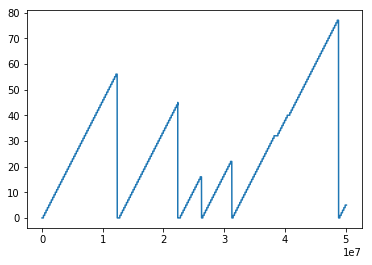

In [125]:
train['After_national_holiday'].plot()

In [126]:
train['After_national_holiday'].tail()

50120527   5.00
50120528   5.00
50120529   5.00
50120530   5.00
50120531   5.00
Name: After_national_holiday, dtype: float64

In [127]:
%time get_elapsed(train, grp_fld='dummy', monitor_fld='national_holiday', after=False)

CPU times: user 2min 35s, sys: 2.93 s, total: 2min 38s
Wall time: 2min 38s


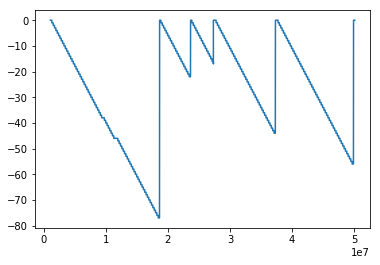

In [128]:
train['Before_national_holiday'].plot()

In [129]:
train.drop(['dummy'], axis=1, inplace=True)

In [130]:
display_all(train.tail().T)

,50120527,50120528,50120529,50120530,50120531
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0.00,0.00,0.00,0.00,0.00
onpromotion,False,False,False,False,False
holiday_type,Transfer,Work Day,Work Day,Work Day,Holiday
holiday_locale,National,Local,Local,Local,Local
holiday_locale_name,Ecuador,None,None,None,Riobamba
holiday_description,Traslado Primer Grito de Independencia,None,None,None,Fundacion de Riobamba


In [131]:
test['dummy'] = 0

In [132]:
%time get_elapsed(test, grp_fld='dummy', monitor_fld='national_holiday')

CPU times: user 9.47 s, sys: 20 ms, total: 9.49 s
Wall time: 9.49 s


In [133]:
%time get_elapsed(test, grp_fld='dummy', monitor_fld='national_holiday', after=False)

CPU times: user 9.48 s, sys: 20 ms, total: 9.5 s
Wall time: 9.5 s


In [134]:
test.drop(['dummy'], axis=1, inplace=True)

In [135]:
display_all(test.tail().T)

,3370459,3370460,3370461,3370462,3370463
id,128867499,128867500,128867501,128867502,128867503
date,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00
store_nbr,54,54,54,54,54
item_nbr,2132163,2132318,2132945,2132957,2134244
onpromotion,False,False,False,False,False
holiday_type,Work Day,Work Day,Work Day,Work Day,Work Day
holiday_locale,Local,Local,Local,Local,Local
holiday_locale_name,None,None,None,None,None
holiday_description,None,None,None,None,None
holiday_transferred,None,None,None,None,None


In [136]:
%%time
train.to_feather(f'{PATH}data/grocery_train')
test.to_feather(f'{PATH}data/grocery_test')

CPU times: user 19.4 s, sys: 7.5 s, total: 26.9 s
Wall time: 1min 13s


In [137]:
%%time
train = pd.read_feather(f'{PATH}data/grocery_train')
test = pd.read_feather(f'{PATH}data/grocery_test')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 23.2 s, sys: 9.5 s, total: 32.7 s
Wall time: 32.7 s


#### 4.2.2 Elapsed for Local Holiday

In [138]:
train.city.unique()

array(['Salinas', 'Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra', 'Guaranda', 'Puyo',
       'Ambato', 'Guayaquil', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca', 'Loja',
       'Machala', 'Esmeraldas', 'Manta', 'El Carmen'], dtype=object)

In [139]:
dict = {}
i = 0
for c in np.sort(train.city.unique()):
    i+=1
    dict[c] = i

In [140]:
city_int = [dict[c] for c in train.city]

In [141]:
train['city_int'] = city_int

In [142]:
%time get_elapsed(train, grp_fld='city_int', monitor_fld='local_holiday')

CPU times: user 2min 21s, sys: 2.37 s, total: 2min 24s
Wall time: 2min 24s


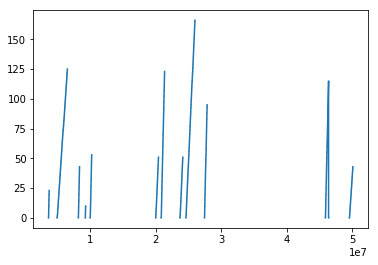

In [143]:
pd.Series(train['After_local_holiday']).plot()

In [144]:
pd.Series(train['After_local_holiday']).tail()

50120527   43.00
50120528   43.00
50120529   43.00
50120530   43.00
50120531   43.00
Name: After_local_holiday, dtype: float64

In [145]:
%time get_elapsed(train, grp_fld='city_int', monitor_fld='local_holiday', after=False)

CPU times: user 2min 22s, sys: 3.24 s, total: 2min 26s
Wall time: 2min 26s


In [146]:
train.drop(['city_int'], axis=1, inplace=True)

In [147]:
display_all(train.tail().T)

,50120527,50120528,50120529,50120530,50120531
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0.00,0.00,0.00,0.00,0.00
onpromotion,False,False,False,False,False
holiday_type,Transfer,Work Day,Work Day,Work Day,Holiday
holiday_locale,National,Local,Local,Local,Local
holiday_locale_name,Ecuador,None,None,None,Riobamba
holiday_description,Traslado Primer Grito de Independencia,None,None,None,Fundacion de Riobamba


In [148]:
city_int = [dict[c] for c in test.city]

In [149]:
test['city_int'] = city_int

In [150]:
%time get_elapsed(test, grp_fld='city_int', monitor_fld='local_holiday')

CPU times: user 9.39 s, sys: 40 ms, total: 9.43 s
Wall time: 9.43 s


In [151]:
%time get_elapsed(test, grp_fld='city_int', monitor_fld='local_holiday', after=False)

CPU times: user 9.54 s, sys: 124 ms, total: 9.67 s
Wall time: 9.67 s


In [152]:
test.drop(['city_int'], axis=1, inplace=True)

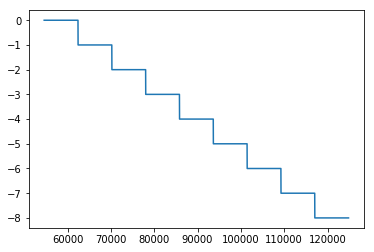

In [153]:
pd.Series(test['Before_local_holiday']).plot()

In [154]:
display_all(test.tail().T)

,3370459,3370460,3370461,3370462,3370463
id,128867499,128867500,128867501,128867502,128867503
date,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00
store_nbr,54,54,54,54,54
item_nbr,2132163,2132318,2132945,2132957,2134244
onpromotion,False,False,False,False,False
holiday_type,Work Day,Work Day,Work Day,Work Day,Work Day
holiday_locale,Local,Local,Local,Local,Local
holiday_locale_name,None,None,None,None,None
holiday_description,None,None,None,None,None
holiday_transferred,None,None,None,None,None


In [155]:
sum(train.After_national_holiday.isnull()), sum(train.Before_national_holiday.isnull()), sum(train.After_local_holiday.isnull()), sum(train.Before_local_holiday.isnull())

(0, 1084860, 43808258, 38191094)

In [156]:
train.After_national_holiday.fillna(0, inplace=True)
train.Before_national_holiday.fillna(0, inplace=True)
train.After_local_holiday.fillna(0, inplace=True)
train.Before_local_holiday.fillna(0, inplace=True)

In [157]:
sum(test.After_national_holiday.isnull()), sum(test.Before_national_holiday.isnull()), sum(test.After_local_holiday.isnull()), sum(test.Before_local_holiday.isnull())

(3370464, 3370464, 3308048, 3300246)

In [158]:
test.After_national_holiday.fillna(0, inplace=True)
test.Before_national_holiday.fillna(0, inplace=True)
test.After_local_holiday.fillna(0, inplace=True)
test.Before_local_holiday.fillna(0, inplace=True)

In [159]:
%%time
train.to_feather(f'{PATH}data/grocery_train')
test.to_feather(f'{PATH}data/grocery_test')

CPU times: user 20.9 s, sys: 8.15 s, total: 29.1 s
Wall time: 1min 21s


In [160]:
%%time
train = pd.read_feather(f'{PATH}data/grocery_train')
test = pd.read_feather(f'{PATH}data/grocery_test')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 23.6 s, sys: 9.53 s, total: 33.1 s
Wall time: 33.1 s


### 4.3 Add Date Part

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.
This makes it possible to capture any trend/cyclical behavior as a function of time at any of these granularities.

In [161]:
%time add_datepart(train, "date", drop=False)

CPU times: user 21.8 s, sys: 1.8 s, total: 23.6 s
Wall time: 23.6 s


In [162]:
%time add_datepart(test, "date", drop=False)

CPU times: user 1.52 s, sys: 32 ms, total: 1.55 s
Wall time: 1.55 s


In [163]:
display_all(train.tail().T)

,50120527,50120528,50120529,50120530,50120531
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0.00,0.00,0.00,0.00,0.00
onpromotion,False,False,False,False,False
holiday_type,Transfer,Work Day,Work Day,Work Day,Holiday
holiday_locale,National,Local,Local,Local,Local
holiday_locale_name,Ecuador,None,None,None,Riobamba
holiday_description,Traslado Primer Grito de Independencia,None,None,None,Fundacion de Riobamba


In [164]:
display_all(test.tail().T)

,3370459,3370460,3370461,3370462,3370463
id,128867499,128867500,128867501,128867502,128867503
date,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00,2017-08-31 00:00:00
store_nbr,54,54,54,54,54
item_nbr,2132163,2132318,2132945,2132957,2134244
onpromotion,False,False,False,False,False
holiday_type,Work Day,Work Day,Work Day,Work Day,Work Day
holiday_locale,Local,Local,Local,Local,Local
holiday_locale_name,None,None,None,None,None
holiday_description,None,None,None,None,None
holiday_transferred,None,None,None,None,None


In [165]:
%%time
train.to_feather(f'{PATH}data/grocery_train_bak')
test.to_feather(f'{PATH}data/grocery_test_bak')

CPU times: user 20.3 s, sys: 8.16 s, total: 28.4 s
Wall time: 25.2 s


In [ ]:
%%time
train = pd.read_feather(f'{PATH}data/grocery_train_bak')
test = pd.read_feather(f'{PATH}data/grocery_test_bak')

In [166]:
train.drop(['local_holiday', 'national_holiday', 'regional_holiday'], axis=1, inplace=True)

In [167]:
test.drop(['local_holiday', 'national_holiday', 'regional_holiday'], axis=1, inplace=True)

In [168]:
train.columns

Index(['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion',
       'holiday_type', 'holiday_locale', 'holiday_locale_name',
       'holiday_description', 'holiday_transferred', 'city', 'state',
       'store_type', 'cluster', 'family', 'class', 'perishable', 'dcoilwtico',
       'holiday_type_Transfer', 'holiday_type_Additional',
       'holiday_type_Event', 'After_national_holiday',
       'Before_national_holiday', 'After_local_holiday',
       'Before_local_holiday', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

In [169]:
train_cats(train)

In [170]:
train_cats(test)

In [171]:
[(n, c.dtype.name) for n, c in train.items() if c.dtype.name != 'category']

[('store_nbr', 'uint64'),
 ('item_nbr', 'uint64'),
 ('date', 'datetime64[ns]'),
 ('id', 'float64'),
 ('unit_sales', 'float32'),
 ('onpromotion', 'bool'),
 ('cluster', 'uint32'),
 ('class', 'uint16'),
 ('perishable', 'bool'),
 ('dcoilwtico', 'int8'),
 ('holiday_type_Transfer', 'bool'),
 ('holiday_type_Additional', 'bool'),
 ('holiday_type_Event', 'bool'),
 ('After_national_holiday', 'float64'),
 ('Before_national_holiday', 'float64'),
 ('After_local_holiday', 'float64'),
 ('Before_local_holiday', 'float64'),
 ('Year', 'int64'),
 ('Month', 'int64'),
 ('Week', 'int64'),
 ('Day', 'int64'),
 ('Dayofweek', 'int64'),
 ('Dayofyear', 'int64'),
 ('Is_month_end', 'bool'),
 ('Is_month_start', 'bool'),
 ('Is_quarter_end', 'bool'),
 ('Is_quarter_start', 'bool'),
 ('Is_year_end', 'bool'),
 ('Is_year_start', 'bool'),
 ('Elapsed', 'int64')]

In [172]:
display_all(train.tail().T)

,50120527,50120528,50120529,50120530,50120531
store_nbr,52,52,52,52,52
item_nbr,2011451,2011451,2011451,2011451,2011451
date,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
id,NaN,NaN,NaN,NaN,NaN
unit_sales,0.00,0.00,0.00,0.00,0.00
onpromotion,False,False,False,False,False
holiday_type,Transfer,Work Day,Work Day,Work Day,Holiday
holiday_locale,National,Local,Local,Local,Local
holiday_locale_name,Ecuador,NaN,NaN,NaN,Riobamba
holiday_description,Traslado Primer Grito de Independencia,NaN,NaN,NaN,Fundacion de Riobamba


In [173]:
cat_vars = ['store_nbr', 'item_nbr', 'onpromotion',
            'holiday_type', 'holiday_locale', 'holiday_locale_name', 'holiday_description', 'holiday_transferred',
            'city', 'state', 'store_type', 'cluster',
            'family', 'class', 'perishable',
            'Year', 'Month', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

contin_vars = ['After_national_holiday', 'Before_national_holiday', 'After_local_holiday', 'Before_local_holiday',
               'dcoilwtico', 'Elapsed', 'date']

In [174]:
%%time
dep = 'unit_sales'
train = train[cat_vars+contin_vars+[dep]].copy()

CPU times: user 3.04 s, sys: 3.04 s, total: 6.09 s
Wall time: 6.09 s


In [175]:
test[dep] = 0
test = test[cat_vars+contin_vars+[dep, 'id']].copy()

In [176]:
%%time
train.to_feather(f'{PATH}data/grocery_train_bak')
test.to_feather(f'{PATH}data/grocery_test_bak')

CPU times: user 6.52 s, sys: 6.31 s, total: 12.8 s
Wall time: 53.7 s


In [ ]:
%%time
train = pd.read_feather(f'{PATH}data/grocery_train_bak')
test = pd.read_feather(f'{PATH}data/grocery_test_bak')

In [177]:
del train
del test

## 5. Exploratory Analysis with Random Forest

In [178]:
%%time
train_forest = pd.read_feather(f'{PATH}data/grocery_train_bak')
test_forest = pd.read_feather(f'{PATH}data/grocery_test_bak')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 3.54 s, sys: 1.67 s, total: 5.22 s
Wall time: 5.22 s


**N.B.: Not possible to save to feather after the next operation !!** (```.astype('category'```)

The problem is that when you load the saved file again from feather the category columns are corrupted. Seems to be a problem in feather

In [179]:
for v in cat_vars: train_forest[v] = train_forest[v].astype('category', ordered=True)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


In [181]:
display_all(train_forest.isnull().sum().sort_index()/len(train_forest))

After_local_holiday       0.00
After_national_holiday    0.00
Before_local_holiday      0.00
Before_national_holiday   0.00
Day                       0.00
Dayofweek                 0.00
Dayofyear                 0.00
Elapsed                   0.00
Is_month_end              0.00
Is_month_start            0.00
Is_quarter_end            0.00
Is_quarter_start          0.00
Is_year_end               0.00
Is_year_start             0.00
Month                     0.00
Year                      0.00
city                      0.00
class                     0.00
cluster                   0.00
date                      0.00
dcoilwtico                0.00
family                    0.00
holiday_description       0.87
holiday_locale            0.00
holiday_locale_name       0.87
holiday_transferred       0.87
holiday_type              0.00
item_nbr                  0.00
onpromotion               0.00
perishable                0.00
state                     0.00
store_nbr                 0.00
store_ty

In [182]:
for v in cat_vars: test_forest[v] = test_forest[v].astype('category', ordered=True)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


In [188]:
train_forest.columns

Index(['store_nbr', 'item_nbr', 'onpromotion', 'holiday_type',
       'holiday_locale', 'holiday_locale_name', 'holiday_description',
       'holiday_transferred', 'city', 'state', 'store_type', 'cluster',
       'family', 'class', 'perishable', 'Year', 'Month', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'After_national_holiday', 'Before_national_holiday',
       'After_local_holiday', 'Before_local_holiday', 'dcoilwtico', 'Elapsed',
       'date', 'unit_sales'],
      dtype='object')

In [189]:
train_forest.drop('date', 1, inplace=True)
test_forest.drop('date', 1, inplace=True)

### 5.1 Prepare Sample

Run on a sample

In [183]:
n = len(train_forest); n

50120532

In [190]:
idxs = get_cv_idxs(n, val_pct=5_000_000/n)
train_samp = train_forest.iloc[idxs].copy()
samp_size = len(train_samp); samp_size

5000000

Whole set

In [ ]:
train_samp = train_forest
samp_size = len(train_samp); samp_size

Replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable:

In [191]:
%time df, y, nas = proc_df(train_samp, 'unit_sales')

CPU times: user 1.15 s, sys: 304 ms, total: 1.45 s
Wall time: 1.45 s


In [192]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = int(samp_size / 10)
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [193]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### 5.2 Random Forest Regressor

In [194]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [195]:
%%time
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.9686901889990035, 0.9689407471908739, 0.1388695606092326, 0.1392131405289313]
CPU times: user 13.3 s, sys: 1.23 s, total: 14.5 s
Wall time: 14.5 s


In [196]:
from IPython.display import display

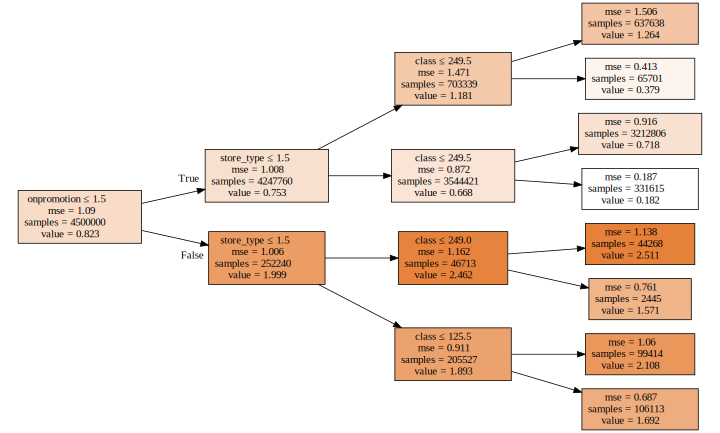

In [197]:
draw_tree(m.estimators_[0], df, precision=3)

In [198]:
%%time
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.4144239048147629, 0.6208294583674467, 0.8423881975838305, 0.6466168635914957, 0.633321173390315]
CPU times: user 43min 2s, sys: 6.34 s, total: 43min 8s
Wall time: 3min 57s


In [199]:
m.score(df, y)

0.8227949225341809

### 5.3 Feature Importance

In [200]:
fi = rf_feat_importance(m, df); fi[:20]

,cols,imp
1,item_nbr,0.25
13,class,0.16
2,onpromotion,0.09
27,Before_national_holiday,0.05
26,After_national_holiday,0.05
19,Dayofyear,0.04
31,Elapsed,0.04
10,store_type,0.04
17,Day,0.04
0,store_nbr,0.04


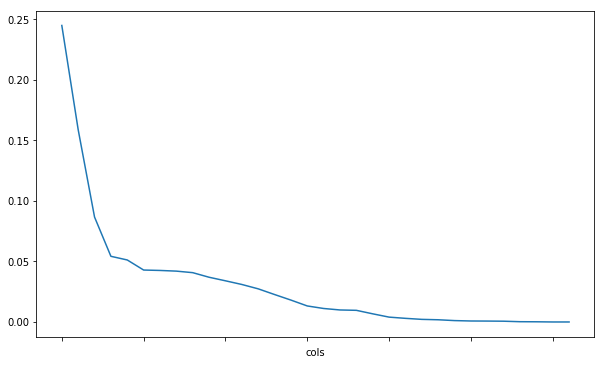

In [201]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [202]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

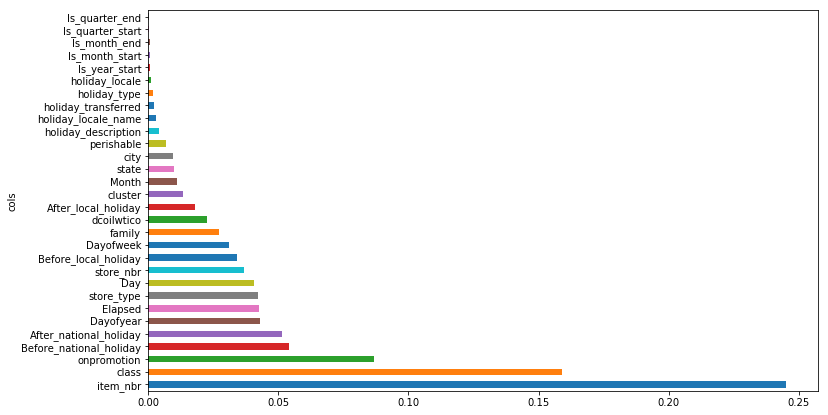

In [203]:
plot_fi(fi[:30]);

In [204]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

20

In [205]:
to_keep

1                    item_nbr
13                      class
2                 onpromotion
27    Before_national_holiday
26     After_national_holiday
19                  Dayofyear
31                    Elapsed
10                 store_type
17                        Day
0                   store_nbr
29       Before_local_holiday
18                  Dayofweek
12                     family
30                 dcoilwtico
28        After_local_holiday
11                    cluster
16                      Month
9                       state
8                        city
14                 perishable
Name: cols, dtype: object

In [206]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [207]:
del df

### 5.4 Redundant Features

In [208]:
%%time
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.41441831920966155, 0.6195588188088628, 0.8423924461387264, 0.6480619080671242, 0.6346553684946473]
CPU times: user 36min 37s, sys: 5.83 s, total: 36min 43s
Wall time: 3min 23s


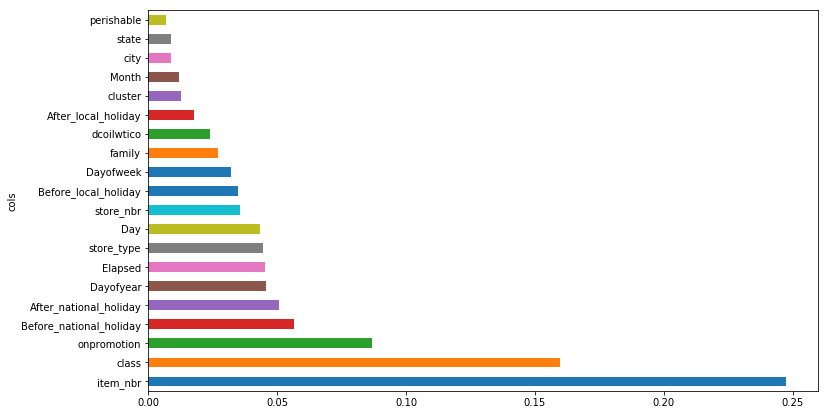

In [209]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [210]:
from scipy.cluster import hierarchy as hc

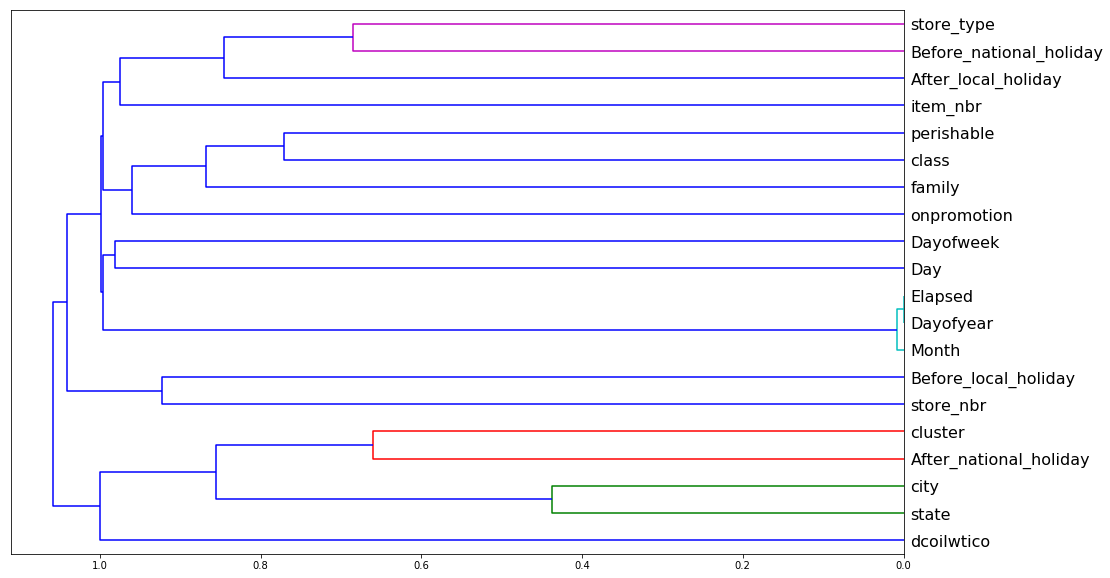

In [211]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [214]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    %time m.fit(x, y_train)
    return m.oob_score_

In [215]:
get_oob(df_keep)

CPU times: user 27min 12s, sys: 2.77 s, total: 27min 15s
Wall time: 2min 20s


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.6458077986542143

In [38]:
%%time
for c in ('Month', 'Dayofyear', 'Elapsed', 'state', 'city'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


CPU times: user 25min 9s, sys: 3.04 s, total: 25min 13s
Wall time: 2min 12s
Month 0.6421212857786847


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


CPU times: user 24min 15s, sys: 2.6 s, total: 24min 17s
Wall time: 2min 11s
Dayofyear 0.6424247998900292


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


CPU times: user 24min 20s, sys: 2.98 s, total: 24min 23s
Wall time: 2min 9s
Elapsed 0.6425079329529224


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


CPU times: user 25min 51s, sys: 2.7 s, total: 25min 53s
Wall time: 2min 16s
state 0.6400091072674562
CPU times: user 25min 30s, sys: 2.89 s, total: 25min 33s
Wall time: 2min 12s
city 0.6442188919088422
CPU times: user 2h 5min 7s, sys: 14.5 s, total: 2h 5min 21s
Wall time: 11min 4s


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


### 5.5 Remove Redundant Features

Remove ```Elapsed```

In [216]:
to_drop = ['Elapsed']
get_oob(df_keep.drop(to_drop, axis=1))

CPU times: user 23min 34s, sys: 2.38 s, total: 23min 36s
Wall time: 2min 5s


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.6428299557478159

In [217]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [218]:
df_keep.columns

Index(['item_nbr', 'class', 'onpromotion', 'Before_national_holiday',
       'After_national_holiday', 'Dayofyear', 'store_type', 'Day', 'store_nbr',
       'Before_local_holiday', 'Dayofweek', 'family', 'dcoilwtico',
       'After_local_holiday', 'cluster', 'Month', 'state', 'city',
       'perishable'],
      dtype='object')

In [219]:
np.save(f'{PATH}data/keep_cols.npy', np.array(df_keep.columns))

In [220]:
keep_cols = np.load(f'{PATH}data/keep_cols.npy').tolist()

In [221]:
keep_cols+['unit_sales']

['item_nbr',
 'class',
 'onpromotion',
 'Before_national_holiday',
 'After_national_holiday',
 'Dayofyear',
 'store_type',
 'Day',
 'store_nbr',
 'Before_local_holiday',
 'Dayofweek',
 'family',
 'dcoilwtico',
 'After_local_holiday',
 'cluster',
 'Month',
 'state',
 'city',
 'perishable',
 'unit_sales']

### 5.6 Split and Save

In [222]:
%%time
train = pd.read_feather(f'{PATH}data/grocery_train_bak')
test = pd.read_feather(f'{PATH}data/grocery_test_bak')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 3.62 s, sys: 1.59 s, total: 5.21 s
Wall time: 5.21 s


In [223]:
del train_forest
del test_forest

In [224]:
keep_cols = np.load(f'{PATH}data/keep_cols.npy').tolist()

In [227]:
train_keep = train[keep_cols+['unit_sales', 'date']].copy()

In [228]:
test_keep = test[keep_cols+['unit_sales', 'id', 'date']].copy()

In [229]:
del train
del test

In [230]:
pd.options.display.float_format = '{:20,.2f}'.format

In [231]:
display_all(train_keep.tail().T)

,50120527,50120528,50120529,50120530,50120531
item_nbr,2011451,2011451,2011451,2011451,2011451
class,1063,1063,1063,1063,1063
onpromotion,False,False,False,False,False
Before_national_holiday,0.00,0.00,0.00,0.00,0.00
After_national_holiday,5.00,5.00,5.00,5.00,5.00
Dayofyear,223,224,225,226,227
store_type,A,A,A,A,A
Day,11,12,13,14,15
store_nbr,52,52,52,52,52
Before_local_holiday,-183.00,-183.00,-183.00,-183.00,-183.00


In [232]:
%%time
train_keep.to_feather(f'{PATH}data/grocery_train_keep')
test_keep.to_feather(f'{PATH}data/grocery_test_keep')

CPU times: user 3.61 s, sys: 3.43 s, total: 7.04 s
Wall time: 3.98 s


### 5.7 Check Reduced Dataset

In [233]:
%%time
train_keep = pd.read_feather(f'{PATH}data/grocery_train_keep')
test_keep = pd.read_feather(f'{PATH}data/grocery_test_keep')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 1.48 s, sys: 1.4 s, total: 2.88 s
Wall time: 2.88 s


In [238]:
train_keep.drop('date', 1, inplace=True)
test_keep.drop('date', 1, inplace=True)

In [239]:
n = len(train_keep); n

50120532

In [240]:
idxs = get_cv_idxs(n, val_pct=5_000_000/n)
train_samp = train_keep.iloc[idxs].copy()
samp_size = len(train_samp); samp_size

5000000

In [241]:
%time df, y, nas = proc_df(train_samp, 'unit_sales')

CPU times: user 2.02 s, sys: 696 ms, total: 2.72 s
Wall time: 2.71 s


In [242]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = int(samp_size / 10)
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [243]:
%%time
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

CPU times: user 26min 40s, sys: 4.01 s, total: 26min 44s
Wall time: 2min 40s


In [244]:
print_score(m)

[0.42264736415051196, 0.622014853673675, 0.8360711212669691, 0.645266094479001, 0.6320563660954142]


In [245]:
from treeinterpreter import treeinterpreter as ti

In [246]:
row = X_valid.values[None,0]; row

array([[1009946, 1036, False, -5.0, 32.0, 210, 4, 29, 42, 0.0, 5, 13, 49, 0.0, 2, 7, 1, 4, False]],
      dtype=object)

In [247]:
%time prediction, bias, contributions = ti.predict(m, row)

CPU times: user 3min 41s, sys: 5.06 s, total: 3min 46s
Wall time: 3min 46s


In [248]:
prediction[0], bias[0]

(0.6883119496750454, 0.8226092476207677)

In [249]:
idxs = np.argsort(contributions[0])

In [250]:
[o for o in zip(X_train.columns[idxs], X_valid.iloc[0][idxs], contributions[0][idxs])]

[('Before_national_holiday', -5.0, -0.225159380514736),
 ('item_nbr', 1009946, -0.11020895643130009),
 ('store_nbr', 42, -0.09207627660515444),
 ('onpromotion', False, -0.06951482054481808),
 ('state', 1, -0.019669363857482546),
 ('cluster', 2, -0.01492813988667847),
 ('city', 4, -0.011077203633611034),
 ('perishable', False, -0.01101274788470355),
 ('family', 13, -0.009037145470259866),
 ('dcoilwtico', 49, -0.009015833732656006),
 ('store_type', 4, -0.0032193226130898993),
 ('Month', 7, 0.00907910813681013),
 ('Before_local_holiday', 0.0, 0.023574604598265055),
 ('class', 1036, 0.024781275621450254),
 ('After_national_holiday', 32.0, 0.03487715211680643),
 ('After_local_holiday', 0.0, 0.044523784107125694),
 ('Day', 29, 0.07947083182562106),
 ('Dayofyear', 210, 0.0883819695443095),
 ('Dayofweek', 5, 0.1359331672783794)]

In [251]:
contributions[0].sum()

-0.13429729794572237

### 5.8 Test

In [252]:
%%time
train_forest = pd.read_feather(f'{PATH}data/grocery_train_keep')
test_forest = pd.read_feather(f'{PATH}data/grocery_test_keep')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 1.58 s, sys: 1.3 s, total: 2.87 s
Wall time: 2.87 s


In [253]:
train_forest.drop('date', 1, inplace=True)
test_forest.drop('date', 1, inplace=True)

In [254]:
cat_vars = ['store_nbr', 'item_nbr', 'onpromotion',
            'city', 'state', 'store_type', 'cluster',
            'family', 'class', 'perishable',
            'Month', 'Day', 'Dayofweek', 'Dayofyear']

**N.B.: Not possible to save to feather after the next operation !!** (```.astype('category'```)

In [255]:
for v in cat_vars: train_forest[v] = train_forest[v].astype('category', ordered=True)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


In [256]:
for v in cat_vars: test_forest[v] = test_forest[v].astype('category', ordered=True)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


In [257]:
train_samp = train_forest
samp_size = len(train_samp); samp_size

50120532

In [258]:
%time df, y, nas, mapper = proc_df(train_samp, 'unit_sales', do_scale=True)

CPU times: user 55 s, sys: 15.5 s, total: 1min 10s
Wall time: 1min 10s


In [259]:
df_test, _, nas, mapper = proc_df(test_forest, 'unit_sales', do_scale=True, skip_flds=['id'],
                                  mapper=mapper, na_dict=nas)

In [260]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = int(samp_size / 10)
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [261]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [14]:
m = RandomForestRegressor(n_estimators=50, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)

CPU times: user 4h 51min 43s, sys: 1min 42s, total: 4h 53min 26s
Wall time: 26min 10s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [15]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [16]:
print_score(m)

[0.19425449410937848, 1.1837456686185706, 0.9653611964402751, -0.27824362642925604, 0.7515611787665316]


In [17]:
pred_test = m.predict(df_test)

In [18]:
df_test["pred_unit_sales"] = pred_test

In [20]:
def inv_y(a): return np.expm1(a)

In [21]:
df_test["unit_sales"] = inv_y(df_test["pred_unit_sales"])

In [22]:
df_test["id"] = test_forest.id

In [28]:
pd.options.display.float_format = '{:20,.2f}'.format

In [29]:
display_all(df_test.tail().T)

,3370459,3370460,3370461,3370462,3370463
item_nbr,"3,897.00","3,898.00","3,899.00","3,900.00","3,901.00"
class,27.00,1.00,15.00,44.00,101.00
onpromotion,1.00,1.00,1.00,1.00,1.00
Before_national_holiday,1.31,1.31,1.31,1.31,1.31
After_national_holiday,-1.32,-1.32,-1.32,-1.32,-1.32
Dayofyear,16.00,16.00,16.00,16.00,16.00
store_type,3.00,3.00,3.00,3.00,3.00
Day,16.00,16.00,16.00,16.00,16.00
store_nbr,54.00,54.00,54.00,54.00,54.00
Before_local_holiday,0.45,0.45,0.45,0.45,0.45


In [24]:
csv_fn = f'{PATH}submission.csv'

In [25]:
df_test[['id','unit_sales']].to_csv(csv_fn, index=False, float_format='%.5f')

In [26]:
FileLink(csv_fn)

/home/ubuntu/fastai/courses/dl1/data/grocery/submission.csv

In [30]:
df_test.pred_unit_sales.describe()

count           3,370,464.00
mean                    1.09
std                     0.76
min                     0.00
25%                     0.51
50%                     0.92
75%                     1.51
max                     5.30
Name: pred_unit_sales, dtype: float64

In [32]:
train_samp.unit_sales.describe()

count          50,120,532.00
mean                    0.82
std                     1.04
min                     0.00
25%                     0.00
50%                     0.00
75%                     1.61
max                     9.75
Name: unit_sales, dtype: float64

## 6. Additional Feature Engineering

I realized that the features we have so far are not sufficient, so after checking forum I adopted this idea from **kevindewalt**

### 6.1 Derive Day-of-the-week Dataframes

see https://github.com/kevindewalt/ai-notebooks/blob/master/Corporaci%C3%B3n+Favorita+Grocery+Sales+Forecasting.ipynb

Dayofweek = dow

'moving average' technique presented by Paulo Pinto and others
https://www.kaggle.com/paulorzp/log-ma-and-days-of-week-means-lb-0-529/code

this isn't a 'moving' average. It is a daily average by store and item.

In [262]:
%%time
train_keep = pd.read_feather(f'{PATH}data/grocery_train_keep')
test_keep = pd.read_feather(f'{PATH}data/grocery_test_keep')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 1.55 s, sys: 1.34 s, total: 2.9 s
Wall time: 2.89 s


In [263]:
display_all(train_keep.tail().T)

,50120527,50120528,50120529,50120530,50120531
item_nbr,2011451,2011451,2011451,2011451,2011451
class,1063,1063,1063,1063,1063
onpromotion,False,False,False,False,False
Before_national_holiday,0.00,0.00,0.00,0.00,0.00
After_national_holiday,5.00,5.00,5.00,5.00,5.00
Dayofyear,223,224,225,226,227
store_type,A,A,A,A,A
Day,11,12,13,14,15
store_nbr,52,52,52,52,52
Before_local_holiday,-183.00,-183.00,-183.00,-183.00,-183.00


In [264]:
#Days of Week Means
#By tarobxl: https://www.kaggle.com/c/favorita-grocery-sales-forecasting/discussion/42948
ma_dw = train_keep[['item_nbr','store_nbr','Dayofweek','unit_sales']].groupby(
        ['item_nbr','store_nbr','Dayofweek'])['unit_sales'].mean().to_frame('madw').reset_index()
ma_wk = ma_dw[['item_nbr','store_nbr','madw']].groupby(
        ['item_nbr', 'store_nbr'])['madw'].mean().to_frame('mawk').reset_index()

In [265]:
pd.options.display.float_format = '{:20,.5f}'.format

In [266]:
ma_dw.head()

,item_nbr,store_nbr,Dayofweek,madw
0,96995,1,0,0.10540
1,96995,1,1,0.02100
2,96995,1,2,0.08664
3,96995,1,3,0.09931
4,96995,1,4,0.17160


In [267]:
ma_wk.head()

,item_nbr,store_nbr,mawk
0,96995,1,0.09913
1,96995,2,0.11815
2,96995,3,0.16567
3,96995,4,0.05421
4,96995,5,0.06770


### 6.2 'Moving' Averages

More correctly stated as static revent averages over a time window.

In [268]:
# Only necessary to create dataframe for the loop below. We copy over 'mais' with median later.
lastdate = train_keep.iloc[train_keep.shape[0]-1].date; lastdate

Timestamp('2017-08-15 00:00:00')

In [269]:
ma_is = train_keep[['item_nbr','store_nbr','unit_sales']].groupby(
    ['item_nbr','store_nbr'])['unit_sales'].mean().to_frame('mais')

In [270]:
ma_is.head()

mais
item_nbr store_nbr                     
96995    1                      0.09931
         2                      0.11855
         3                      0.16656
         4                      0.05503
         5                      0.06703

In [271]:
from datetime import timedelta

In [272]:
# Now calculate average sales of store/item combinations over recent time windows 
# based on days before the last available training data date.
# e.g. 112 days before the last date, 56 before the last date ...
for i in [112, 56, 28, 14, 7, 3, 1]:
    tmp = train_keep[train_keep.date>lastdate-timedelta(int(i))]
    tmpg = tmp.groupby(['item_nbr', 'store_nbr'])['unit_sales'].mean().to_frame('mais'+str(i))
    ma_is =  ma_is.join(tmpg, how='left')

In [273]:
del tmp; del tmpg

In [274]:
ma_is.head()

mais              mais112  \
item_nbr store_nbr                                             
96995    1                      0.09931              0.16229   
         2                      0.11855              0.15774   
         3                      0.16656              0.22154   
         4                      0.05503              0.11054   
         5                      0.06703              0.13465   

                                 mais56               mais28  \
item_nbr store_nbr                                             
96995    1                      0.18709              0.29520   
         2                      0.11748              0.04951   
         3                      0.30745              0.33630   
         4                      0.18022              0.09902   
         5                      0.19196              0.23728   

                                 mais14                mais7  \
item_nbr store_nbr                                             
96995    1                      0.33444              0.09902   
         2                      0.00000              0.00000   
         3                      0.37554              0.45401   
         4                      0.09902              0.19804   
         5                      0.09902              0.19804   

                                  mais3                mais1  
item_nbr store_nbr                                            
96995    1                      0.00000              0.00000  
         2                      0.00000              0.00000  
         3                      0.46210              0.69315  
         4                      0.23105              0.69315  
         5                      0.00000              0.00000

In [275]:
# Now take the median of of the day windows we calculated.
# I tried just keeping all of the windows but got worse results.
# Perhaps mean would work as well as median - I didn't test it.
# In any case, this is a pretty simplistic feature which may not generalize.
ma_is['mais']=ma_is.median(axis=1)

In [276]:
# Now remove the mais112 ... mais1 and merge the mais feature with training dataframe
ma_is.reset_index(inplace=True)
ma_is.drop(list(ma_is.columns.values)[3:],1,inplace=True)

In [277]:
train_keep=join_df(train_keep,ma_is,['item_nbr', 'store_nbr'])

In [278]:
train_keep.columns

Index(['item_nbr', 'class', 'onpromotion', 'Before_national_holiday',
       'After_national_holiday', 'Dayofyear', 'store_type', 'Day', 'store_nbr',
       'Before_local_holiday', 'Dayofweek', 'family', 'dcoilwtico',
       'After_local_holiday', 'cluster', 'Month', 'state', 'city',
       'perishable', 'unit_sales', 'date', 'mais'],
      dtype='object')

In [279]:
# now you see the purpose of 'madw' and 'mawk'. To scale each sales average by
# how well it historically sells for that day of the week
train_keep = pd.merge(train_keep, ma_wk, how='left', on=['item_nbr','store_nbr'])
train_keep = pd.merge(train_keep, ma_dw, how='left', on=['item_nbr','store_nbr','Dayofweek'])

In [280]:
train_keep.columns

Index(['item_nbr', 'class', 'onpromotion', 'Before_national_holiday',
       'After_national_holiday', 'Dayofyear', 'store_type', 'Day', 'store_nbr',
       'Before_local_holiday', 'Dayofweek', 'family', 'dcoilwtico',
       'After_local_holiday', 'cluster', 'Month', 'state', 'city',
       'perishable', 'unit_sales', 'date', 'mais', 'mawk', 'madw'],
      dtype='object')

In [281]:
train_keep['m_ratio'] = train_keep['mais']*train_keep['madw']/train_keep['mawk']

In [282]:
train_keep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50120532 entries, 0 to 50120531
Data columns (total 25 columns):
item_nbr                   uint64
class                      uint16
onpromotion                bool
Before_national_holiday    float64
After_national_holiday     float64
Dayofyear                  int64
store_type                 category
Day                        int64
store_nbr                  uint64
Before_local_holiday       float64
Dayofweek                  int64
family                     category
dcoilwtico                 int8
After_local_holiday        float64
cluster                    uint32
Month                      int64
state                      category
city                       category
perishable                 bool
unit_sales                 float32
date                       datetime64[ns]
mais                       float32
mawk                       float32
madw                       float32
m_ratio                    float32
dtypes: bool(2), cat

Shrink size

In [283]:
train_keep['store_nbr'] = train_keep['store_nbr'].astype(np.uint8)
train_keep['item_nbr'] = train_keep['item_nbr'].astype(np.uint32)
train_keep['Before_national_holiday'] = train_keep['Before_national_holiday'].astype(np.uint8)
train_keep['After_national_holiday'] = train_keep['After_national_holiday'].astype(np.uint8)
train_keep['Dayofyear'] = train_keep['Dayofyear'].astype(np.uint8)
train_keep['Day'] = train_keep['Day'].astype(np.uint8)
train_keep['Before_local_holiday'] = train_keep['Before_local_holiday'].astype(np.uint8)
train_keep['Dayofweek'] = train_keep['Dayofweek'].astype(np.uint8)
train_keep['After_local_holiday'] = train_keep['After_local_holiday'].astype(np.uint8)
train_keep['cluster'] = train_keep['cluster'].astype(np.uint8)
train_keep['Month'] = train_keep['Month'].astype(np.uint8)

train_keep.drop('mawk', 1, inplace=True)
train_keep.drop('madw', 1, inplace=True)
train_keep.drop('mais', 1, inplace=True)

In [284]:
train_keep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50120532 entries, 0 to 50120531
Data columns (total 22 columns):
item_nbr                   uint32
class                      uint16
onpromotion                bool
Before_national_holiday    uint8
After_national_holiday     uint8
Dayofyear                  uint8
store_type                 category
Day                        uint8
store_nbr                  uint8
Before_local_holiday       uint8
Dayofweek                  uint8
family                     category
dcoilwtico                 int8
After_local_holiday        uint8
cluster                    uint8
Month                      uint8
state                      category
city                       category
perishable                 bool
unit_sales                 float32
date                       datetime64[ns]
m_ratio                    float32
dtypes: bool(2), category(4), datetime64[ns](1), float32(2), int8(1), uint16(1), uint32(1), uint8(10)
memory usage: 2.2 GB


Same for test data

In [285]:
test_keep = pd.merge(test_keep, ma_is, how='left', on=['item_nbr','store_nbr'])
test_keep = pd.merge(test_keep, ma_wk, how='left', on=['item_nbr','store_nbr'])
test_keep = pd.merge(test_keep, ma_dw, how='left', on=['item_nbr','store_nbr','Dayofweek'])

In [286]:
test_keep['m_ratio'] = test_keep['mais']*test_keep['madw']/test_keep['mawk']

In [287]:
test_keep['store_nbr'] = test_keep['store_nbr'].astype(np.uint8)
test_keep['item_nbr'] = test_keep['item_nbr'].astype(np.uint32)
test_keep['Before_national_holiday'] = test_keep['Before_national_holiday'].astype(np.uint8)
test_keep['After_national_holiday'] = test_keep['After_national_holiday'].astype(np.uint8)
test_keep['Dayofyear'] = test_keep['Dayofyear'].astype(np.uint8)
test_keep['Day'] = test_keep['Day'].astype(np.uint8)
test_keep['Before_local_holiday'] = test_keep['Before_local_holiday'].astype(np.uint8)
test_keep['Dayofweek'] = test_keep['Dayofweek'].astype(np.uint8)
test_keep['After_local_holiday'] = test_keep['After_local_holiday'].astype(np.uint8)
test_keep['cluster'] = test_keep['cluster'].astype(np.uint8)
test_keep['Month'] = test_keep['Month'].astype(np.uint8)

test_keep.drop('mawk', 1, inplace=True)
test_keep.drop('madw', 1, inplace=True)
test_keep.drop('mais', 1, inplace=True)

In [288]:
del ma_is; del ma_wk; del ma_dw

In [289]:
len(train_keep['m_ratio'].isna()), len(test_keep['m_ratio'].isna())

(50120532, 3370464)

In [290]:
train_keep['m_ratio'].fillna(0, inplace=True)
test_keep['m_ratio'].fillna(0, inplace=True)

In [291]:
%%time
train_keep.to_feather(f'{PATH}data/grocery_train_ma')
test_keep.to_feather(f'{PATH}data/grocery_test_ma')

CPU times: user 1.69 s, sys: 1.43 s, total: 3.12 s
Wall time: 1.83 s


## 7. Another Look at the Data

In [292]:
%%time
train_keep = pd.read_feather(f'{PATH}data/grocery_train_ma')
test_keep = pd.read_feather(f'{PATH}data/grocery_test_ma')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 1.04 s, sys: 392 ms, total: 1.43 s
Wall time: 1.43 s


In [293]:
train_keep.drop('date', 1, inplace=True)
test_keep.drop('date', 1, inplace=True)

In [294]:
display_all(train_keep.tail().T)

,50120527,50120528,50120529,50120530,50120531
item_nbr,2011451,2011451,2011451,2011451,2011451
class,1063,1063,1063,1063,1063
onpromotion,False,False,False,False,False
Before_national_holiday,0,0,0,0,0
After_national_holiday,5,5,5,5,5
Dayofyear,223,224,225,226,227
store_type,A,A,A,A,A
Day,11,12,13,14,15
store_nbr,52,52,52,52,52
Before_local_holiday,73,73,73,73,73


How many observations?

In [295]:
n = len(train_keep); n

50120532

How many features? (```unit_sales``` is target, and has been transformed by $log(x) + 1$)

In [296]:
len(train_keep.columns), train_keep.columns

(21, Index(['item_nbr', 'class', 'onpromotion', 'Before_national_holiday',
        'After_national_holiday', 'Dayofyear', 'store_type', 'Day', 'store_nbr',
        'Before_local_holiday', 'Dayofweek', 'family', 'dcoilwtico',
        'After_local_holiday', 'cluster', 'Month', 'state', 'city',
        'perishable', 'unit_sales', 'm_ratio'],
       dtype='object'))

What are the data types?

In [297]:
sorted([(c.dtype.name, n) for n, c in train_keep.items()], key=lambda tup: (tup[0], tup[1].lower()))

[('bool', 'onpromotion'),
 ('bool', 'perishable'),
 ('category', 'city'),
 ('category', 'family'),
 ('category', 'state'),
 ('category', 'store_type'),
 ('float32', 'm_ratio'),
 ('float32', 'unit_sales'),
 ('int8', 'dcoilwtico'),
 ('uint16', 'class'),
 ('uint32', 'item_nbr'),
 ('uint8', 'After_local_holiday'),
 ('uint8', 'After_national_holiday'),
 ('uint8', 'Before_local_holiday'),
 ('uint8', 'Before_national_holiday'),
 ('uint8', 'cluster'),
 ('uint8', 'Day'),
 ('uint8', 'Dayofweek'),
 ('uint8', 'Dayofyear'),
 ('uint8', 'Month'),
 ('uint8', 'store_nbr')]

Some samples

In [298]:
display_all(train_keep.head())

,item_nbr,class,onpromotion,Before_national_holiday,After_national_holiday,Dayofyear,store_type,Day,store_nbr,Before_local_holiday,Dayofweek,family,dcoilwtico,After_local_holiday,cluster,Month,state,city,perishable,unit_sales,m_ratio
0,99197,1067,False,0,0,1,D,1,25,0,6,GROCERY I,52,0,1,1,Santa Elena,Salinas,False,0.69315,0.22705
1,99197,1067,False,0,0,2,D,2,25,0,0,GROCERY I,52,0,1,1,Santa Elena,Salinas,False,0.00000,0.26226
2,99197,1067,False,0,0,3,D,3,25,0,1,GROCERY I,52,0,1,1,Santa Elena,Salinas,False,1.09861,0.33897
3,99197,1067,False,0,0,4,D,4,25,0,2,GROCERY I,53,0,1,1,Santa Elena,Salinas,False,1.60944,0.41654
4,99197,1067,False,0,0,5,D,5,25,0,3,GROCERY I,53,0,1,1,Santa Elena,Salinas,False,1.09861,0.27865


Are there any NAs?

In [299]:
display_all(train_keep.isnull().sum().sort_index())

After_local_holiday        0
After_national_holiday     0
Before_local_holiday       0
Before_national_holiday    0
Day                        0
Dayofweek                  0
Dayofyear                  0
Month                      0
city                       0
class                      0
cluster                    0
dcoilwtico                 0
family                     0
item_nbr                   0
m_ratio                    0
onpromotion                0
perishable                 0
state                      0
store_nbr                  0
store_type                 0
unit_sales                 0
dtype: int64

Plot Numerical Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04ed543320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f02b2a13240>]], dtype=object)

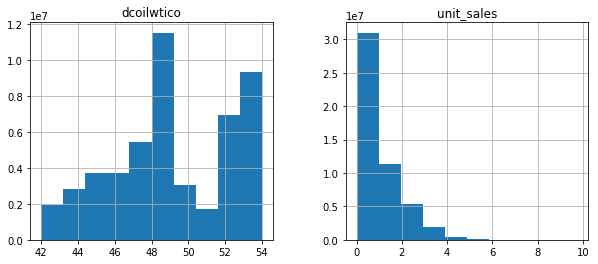

In [300]:
train_keep[['unit_sales', 'dcoilwtico']].hist(figsize=(10, 4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0830027dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f04ed561c50>]], dtype=object)

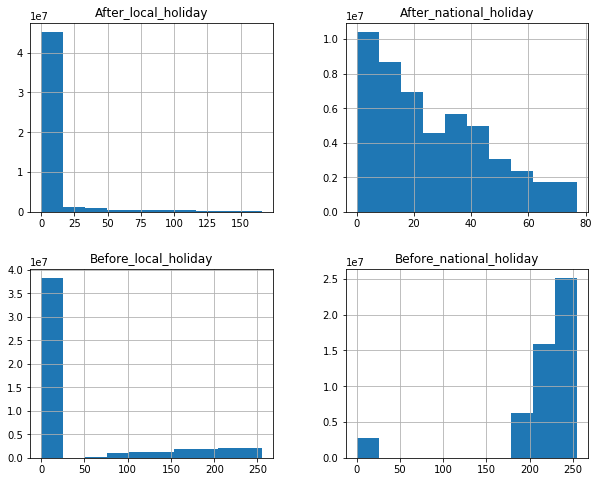

In [301]:
train_keep[['Before_national_holiday', 'After_local_holiday', 
            'Before_local_holiday', 'After_national_holiday']].hist(figsize=(10, 8))

In [304]:
sorted(train_keep.select_dtypes(include=['category']).columns)

['city', 'family', 'state', 'store_type']

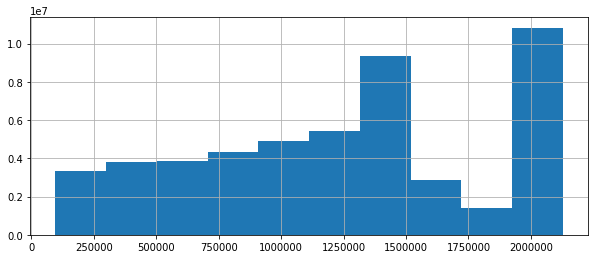

In [306]:
train_keep['item_nbr'].hist(figsize=(10, 4))

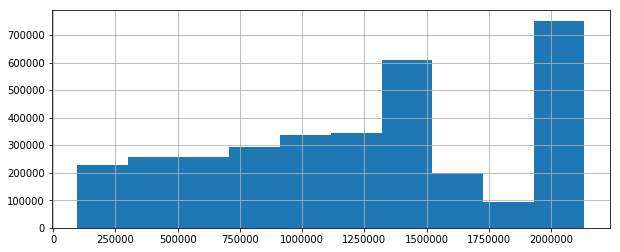

In [307]:
test_keep['item_nbr'].hist(figsize=(10, 4))

## 8 Training

In [309]:
%%time
train_keep = pd.read_feather(f'{PATH}data/grocery_train_ma')
test_keep = pd.read_feather(f'{PATH}data/grocery_test_ma')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 1.02 s, sys: 412 ms, total: 1.43 s
Wall time: 1.43 s


In [310]:
train_keep.drop('date', 1, inplace=True)
test_keep.drop('date', 1, inplace=True)

In [311]:
cat_vars = ['store_nbr', 'item_nbr', 'onpromotion',
            'city', 'state', 'store_type', 'cluster',
            'family', 'class', 'perishable',
            'Month', 'Day', 'Dayofweek', 'Dayofyear']

**N.B.: Not possible to save to feather after the next operation !!** (```.astype('category'```)

In [312]:
for v in cat_vars: train_keep[v] = train_keep[v].astype('category', ordered=True)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


In [313]:
for v in cat_vars: test_keep[v] = test_keep[v].astype('category', ordered=True)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


In [314]:
n = len(train_keep); n

50120532

Sample

In [315]:
idxs = get_cv_idxs(n, val_pct=5_000_000/n)
train_samp = train_keep.iloc[idxs].copy()
samp_size = len(train_samp); samp_size

5000000

Complete set:

In [11]:
samp_size = n
train_samp = train_keep.copy()

In [316]:
%time df, y, nas, mapper = proc_df(train_samp, 'unit_sales', do_scale=True)

CPU times: user 7.06 s, sys: 1.24 s, total: 8.3 s
Wall time: 8.3 s


In [317]:
pd.options.display.float_format = '{:20,.2f}'.format

In [318]:
display_all(df.tail().T)

,41939834,48705124,46803342,25948542,21808618
item_nbr,"1,584.00","1,323.00",90.00,"3,811.00","2,042.00"
class,160.00,135.00,232.00,53.00,222.00
onpromotion,2.00,1.00,1.00,1.00,1.00
Before_national_holiday,0.37,-0.18,-0.02,0.55,0.48
After_national_holiday,0.98,2.53,2.08,-0.57,0.78
Dayofyear,167.00,160.00,198.00,82.00,139.00
store_type,1.00,3.00,1.00,5.00,4.00
Day,16.00,9.00,17.00,23.00,19.00
store_nbr,46.00,54.00,51.00,28.00,23.00
Before_local_holiday,-0.53,1.88,-0.53,2.02,-0.53


In [319]:
df_test, _, nas, mapper = proc_df(test_keep.copy(), 'unit_sales', do_scale=True, skip_flds=['id'],
                                  mapper=mapper, na_dict=nas)

In [320]:
# train_ratio = 0.75
train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [321]:
keep_cols = np.load(f'{PATH}data/keep_cols.npy').tolist()

In [322]:
keep_cat_vars = list(set(keep_cols).intersection(set(cat_vars)))
keep_cat_vars

['Day',
 'Month',
 'cluster',
 'Dayofyear',
 'city',
 'class',
 'store_nbr',
 'family',
 'store_type',
 'perishable',
 'state',
 'item_nbr',
 'onpromotion',
 'Dayofweek']

In [323]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32), cat_flds=keep_cat_vars, bs=128,
                                       test_df=df_test)

### 8.1 Create Embeddings

In [324]:
cat_sz = [(c, len(train_samp[c].cat.categories)+1) for c in keep_cat_vars]
cat_sz

[('Day', 32),
 ('Month', 9),
 ('cluster', 18),
 ('Dayofyear', 228),
 ('city', 23),
 ('class', 335),
 ('store_nbr', 55),
 ('family', 34),
 ('store_type', 6),
 ('perishable', 3),
 ('state', 17),
 ('item_nbr', 4019),
 ('onpromotion', 3),
 ('Dayofweek', 8)]

In [325]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(32, 16),
 (9, 5),
 (18, 9),
 (228, 50),
 (23, 12),
 (335, 50),
 (55, 28),
 (34, 17),
 (6, 3),
 (3, 2),
 (17, 9),
 (4019, 50),
 (3, 2),
 (8, 4)]

In [326]:
max_log_y = np.max(y)
y_range = (0, max_log_y*1.2)

In [327]:
m = md.get_learner(emb_szs, len(df.columns)-len(keep_cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [328]:
m.lr_find()

 58%|█████▊    | 20252/35157 [02:03<01:31, 163.57it/s, loss=1.13] 

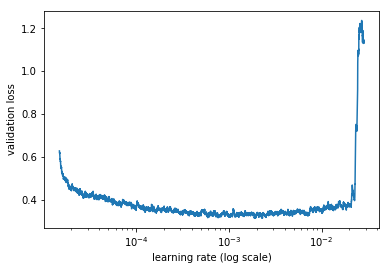

In [332]:
m.sched.plot(1000)

In [333]:
lr = 1e-3

In [334]:
def inv_y(a):
    return np.expm1(a)

def exp_rmspe(y_pred, targ):
    return math.sqrt(((targ - y_pred)**2).sum())

In [335]:
inv_y(y)[:10]

array([ 0.,  0., 15., 10.,  0.,  0.,  5.,  2.,  0.,  0.], dtype=float32)

In [336]:
%%time
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.286988   0.284874   8.514985  
    1      0.280247   0.274277   8.355234                         
    2      0.273987   0.274879   8.364321                         
CPU times: user 11min 9s, sys: 19.4 s, total: 11min 28s
Wall time: 10min 51s


[array([0.27488]), 8.364321197482585]

In [337]:
%%time
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.255079   0.258873   8.116612  
    1      0.254134   0.257833   8.100403                         
    2      0.246636   0.256994   8.087222                         
CPU times: user 11min 14s, sys: 18.6 s, total: 11min 33s
Wall time: 10min 55s


[array([0.25699]), 8.087221688975134]

### 8.2 Test

In [338]:
display_all(test_keep.tail().T)

,3370459,3370460,3370461,3370462,3370463
item_nbr,2132163,2132318,2132945,2132957,2134244
class,1040,1002,1026,1068,1364
onpromotion,False,False,False,False,False
Before_national_holiday,0,0,0,0,0
After_national_holiday,0,0,0,0,0
Dayofyear,243,243,243,243,243
store_type,C,C,C,C,C
Day,31,31,31,31,31
store_nbr,54,54,54,54,54
Before_local_holiday,0,0,0,0,0


In [339]:
pd.options.display.float_format = '{:20,.5f}'.format

In [340]:
display_all(df_test.tail().T)

,3370459,3370460,3370461,3370462,3370463
item_nbr,"3,897.00000","3,898.00000","3,899.00000","3,900.00000","3,901.00000"
class,27.00000,1.00000,15.00000,44.00000,101.00000
onpromotion,1.00000,1.00000,1.00000,1.00000,1.00000
Before_national_holiday,-3.85299,-3.85299,-3.85299,-3.85299,-3.85299
After_national_holiday,-1.31753,-1.31753,-1.31753,-1.31753,-1.31753
Dayofyear,16.00000,16.00000,16.00000,16.00000,16.00000
store_type,3.00000,3.00000,3.00000,3.00000,3.00000
Day,16.00000,16.00000,16.00000,16.00000,16.00000
store_nbr,54.00000,54.00000,54.00000,54.00000,54.00000
Before_local_holiday,-0.52578,-0.52578,-0.52578,-0.52578,-0.52578


In [341]:
%%time
pred_test = m.predict(True)

CPU times: user 1min 16s, sys: 1.35 s, total: 1min 17s
Wall time: 1min 11s


In [342]:
df_test["pred_unit_sales"] = pred_test

In [343]:
df_test["unit_sales"] = inv_y(df_test["pred_unit_sales"])

In [344]:
df_test.pred_unit_sales.describe()

count        3,370,464.00000
mean                 0.78157
std                  0.82085
min                  0.00000
25%                  0.05729
50%                  0.53136
75%                  1.27366
max                  6.09357
Name: pred_unit_sales, dtype: float64

In [345]:
train_keep.unit_sales.describe()

count       50,120,532.00000
mean                 0.82229
std                  1.04408
min                  0.00000
25%                  0.00000
50%                  0.00000
75%                  1.60944
max                  9.74958
Name: unit_sales, dtype: float64

In [346]:
df_test["id"] = test_keep.id

In [347]:
display_all(df_test.tail().T)

,3370459,3370460,3370461,3370462,3370463
item_nbr,"3,897.00000","3,898.00000","3,899.00000","3,900.00000","3,901.00000"
class,27.00000,1.00000,15.00000,44.00000,101.00000
onpromotion,1.00000,1.00000,1.00000,1.00000,1.00000
Before_national_holiday,-3.85299,-3.85299,-3.85299,-3.85299,-3.85299
After_national_holiday,-1.31753,-1.31753,-1.31753,-1.31753,-1.31753
Dayofyear,16.00000,16.00000,16.00000,16.00000,16.00000
store_type,3.00000,3.00000,3.00000,3.00000,3.00000
Day,16.00000,16.00000,16.00000,16.00000,16.00000
store_nbr,54.00000,54.00000,54.00000,54.00000,54.00000
Before_local_holiday,-0.52578,-0.52578,-0.52578,-0.52578,-0.52578


In [348]:
csv_fn = f'{PATH}submission.csv'

In [349]:
df_test[['id','unit_sales']].to_csv(csv_fn, index=False, float_format='%.5f')

In [350]:
FileLink(csv_fn)

/home/ubuntu/fastai/courses/dl1/data/grocery/submission.csv

## 8. Conclusions

It turned out that it is not enough just to throw this problem at a deep neural network and hope for the best. After a lot of struggling I realized that the key to getting better scores on this competition is to create new features. Once I added a feature - "moving average",  that someone else had come up with - there was a huge improvement. Before I had nothing - a score much worse than even the sample submission, which are only zeros ! After adding this engineered feature I suddenly had at least something - close to the mean item sales benchmark, which is of course also not very impressing. I conclude that the way to improve further is to go through the kernels and find more of those ingenious features that people have come up with. But I will not invest more time in this competition, at least not at this point in time.

In my view this was quite a challenging data set to have for a competition, and in the discussions I have seen similar comments. First of all there is an issue that the training set has been stripped of all 0-sales, so you need to recreate those lines because otherwise you will have no information at all on most of the item / store combinations of the test set. How should you be able to predict anything about something you have never seen? I wanted to learn the most, so at the beginning I didn't look into any forums or kernels and tried it out myself, and it took only quite long til I realized this huge issue. You can do any learning you want without getting one millimeter ahead if you do not fully understand the deficiencies of the data set(s) you are working on. 

Another conclusion is that the approach we used in the course for the Rossmann competition is not 1:1 applicable on this data set. Without the extra feature engineering you are lost. For the Rossman we did create some own features, in particular the "elapsed time" features, but also the "add_datepart" can be counted as feature engineering. Maybe I was a bit naive about this aspect, after all we are dealing with a time series, and you need to adress that somehow. I have seen in the kernels that the good guys are using LSTMs, so maybe I will come back to this competition once I have learned more about LSTMs.

All that said, I am not the least disappointed about my scores, because this was a great learning experience. Not only did I learn a lot about the practical use of the fast-ai library, and pandas, but I also had to learn not to give up in the face of very frustrating setbacks. I did not only struggle with the machine learning as such, but much more with the practicalities of handling huge data sets, finding the right pandas tools for some particular task, handling subtle bugs and so on...

Final word: Kaggle competitions is a great way to learn, because you get a feedback via the scores if you are on the right track or totally off-track. You can learn from others, and learn by doing. And Kaggle competitions make a lot of fun too. 